In [1]:
import time
import math
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import numpy as np
from pprint import pprint

from tsp import *
import tb
import ga
import sa


In [2]:
# load data
pos = [[float(x) for x in s.split()[1:]] for s in open('data/dj38.txt').readlines()]
n = len(pos)


# calculate adjacency matrix
adj_mat = np.zeros([n, n])
for i in range(n):
    for j in range(i, n):
        adj_mat[i][j] = adj_mat[j][i] = np.linalg.norm(np.subtract(pos[i], pos[j]))


# initialization
opt_cost = 6659.439330623091  # get result from tsp_gurobi.py
num_tests = 1  # number of iid tests

In [3]:
# Set Mutation methods
mut_md = [get_new_sol_2opt, get_delta_2opt]

all_results = {}
all_data = {}

methods = ['ts', 'ga', 'sa']
method_names = {'ts': 'Tabu Search', 'ga': 'Genetic Algorithm', 'sa': 'Simulated Annealing'}


运行: Tabu Search 算法


100%|██████████| 1/1 [00:00<00:00,  3.97it/s]


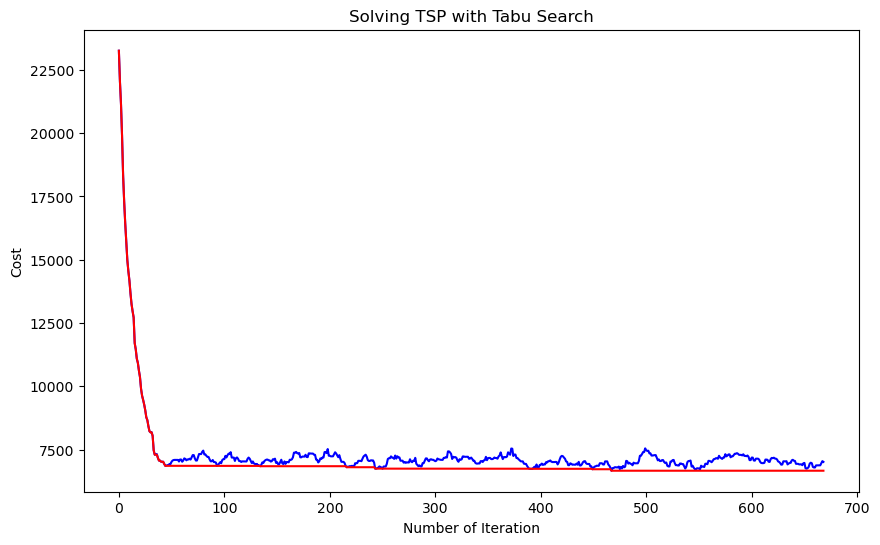

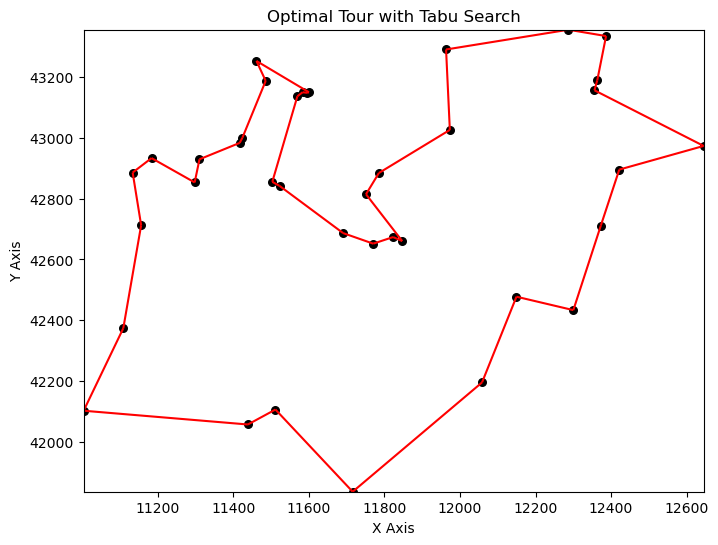


运行: Genetic Algorithm 算法


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


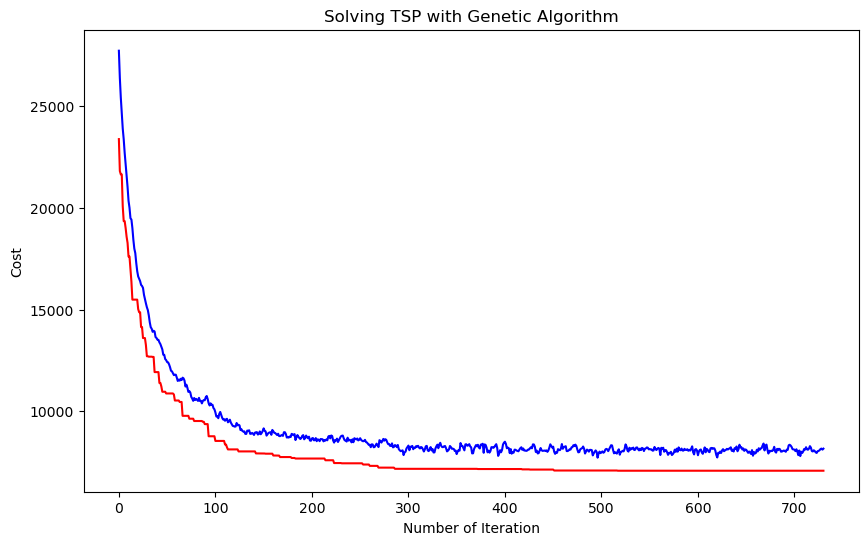

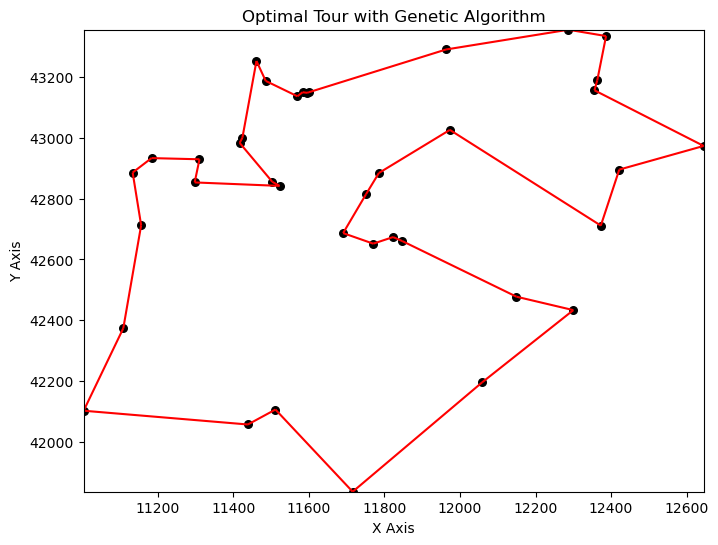


运行: Simulated Annealing 算法


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


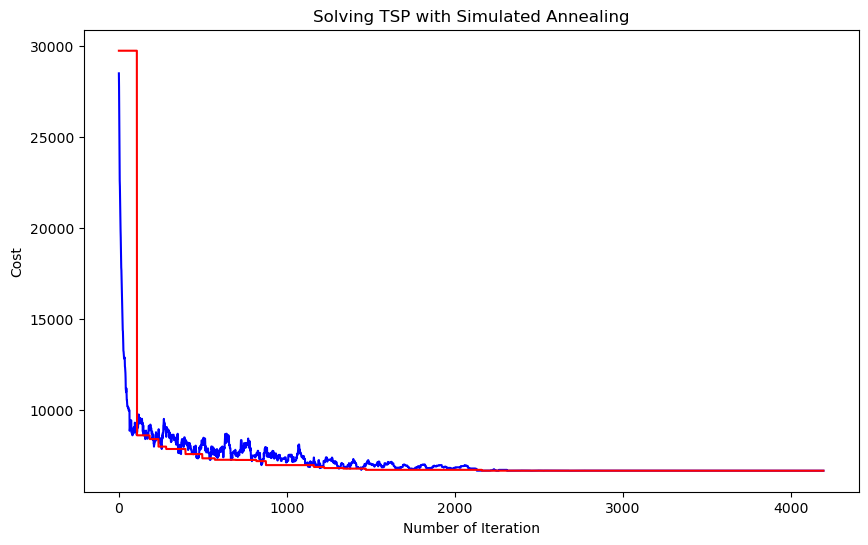

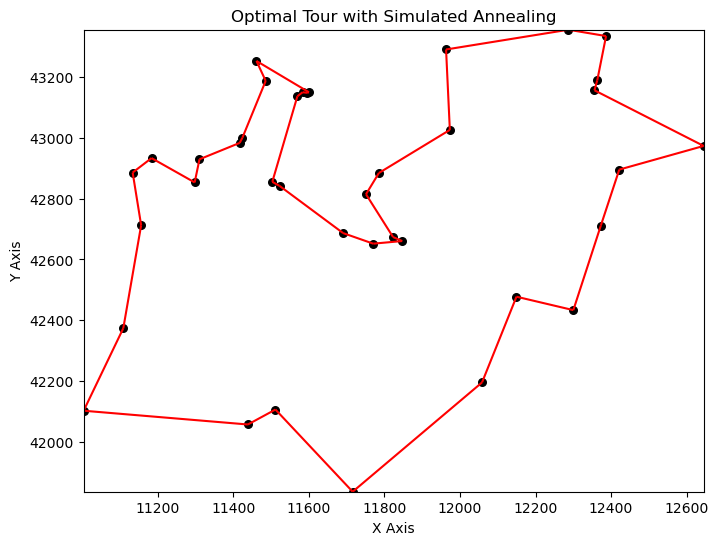

In [4]:
for method in methods:
    print(f"\n运行: {method_names[method]} 算法")

    result = {'best_sol': [], 'best_cost': math.inf, 'best_gap': math.inf,
              'cost': [0] * num_tests, 'time': [0] * num_tests,
              'avg_cost': math.inf, 'avg_gap': math.inf, 'cost_std': math.inf,
              'avg_time': math.inf, 'time_std': math.inf}

    plt.figure(figsize=(10, 6))

    for _ in tqdm(range(num_tests)):
        start = time.time()

        if method == 'ts':
            best_sol, best_cost, data = tb.tb(n, adj_mat, tb_size=20, max_tnm=100, 
                                      mut_md=mut_md, term_count=200)
        elif method == 'ga':
            best_sol, best_cost, data = ga.ga(n, adj_mat, n_pop=200, r_cross=0.5, 
                                      r_mut=0.8, selection_md='tnm', max_tnm=3, term_count=200)
        elif method == 'sa':
            best_sol, best_cost, data = sa.sa(n, adj_mat, tb_size=0, max_tnm=20, mut_md=mut_md,
                                      term_count_1=25, term_count_2=25, t_0=1200, alpha=0.9)

        end = time.time()
        result['time'][_] = end - start
        result['cost'][_] = best_cost

        if best_cost < result['best_cost']:
            result['best_sol'] = best_sol
            result['best_cost'] = best_cost
            result['best_gap'] = best_cost / opt_cost - 1

        plt.plot(range(len(data['cost'])), data['cost'], color='b', alpha=math.pow(num_tests, -0.75))
        plt.plot(range(len(data['best_cost'])), data['best_cost'], color='r', alpha=math.pow(num_tests, -0.75))

    plt.title(f'Solving TSP with {method_names[method]}')
    plt.xlabel('Number of Iteration')
    plt.ylabel('Cost')
    plt.show(f'{method}.png')

    result['avg_cost'] = np.mean(result['cost'])
    result['avg_gap'] = result['avg_cost'] / opt_cost - 1
    result['cost_std'] = np.std(result['cost'])
    result['avg_time'] = np.mean(result['time'])
    result['time_std'] = np.std(result['time'])

    all_results[method] = result
    all_data[method] = data

    # 生成路径可视化
    if num_tests == 1:
        fig, ax = plt.subplots(figsize=(8, 6))
        
        final_sol = data['best_sol'][-1]
        
        xlim = [np.min(pos, 0)[0], np.max(pos, 0)[0]]
        ylim = [np.min(pos, 0)[1], np.max(pos, 0)[1]]
        ax.set(xlabel='X Axis', ylabel='Y Axis',
              xlim=xlim, ylim=ylim,
              title=f'Optimal Tour with {method_names[method]}')

        ax.scatter([p[0] for p in pos], [p[1] for p in pos], c='black', s=30)

        lines = [[pos[final_sol[i]], pos[final_sol[(i + 1) % n]]] for i in range(n)]
        line_segments = LineCollection(lines, color='r', linewidth=1.5)
        ax.add_collection(line_segments)
        plt.show(f'{method}_path.png')

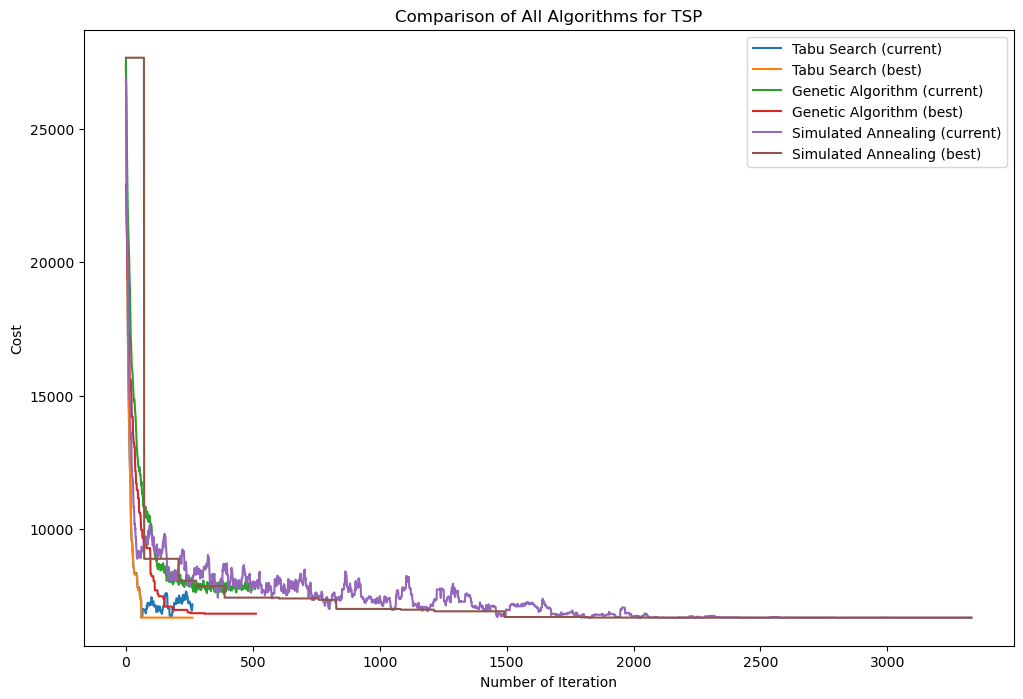


所有算法的性能比较:
Tabu Search: 最佳成本 = 6662.82, 平均时间 = 0.13s, 与最优解的差距 = 0.05%
Genetic Algorithm: 最佳成本 = 6810.97, 平均时间 = 2.02s, 与最优解的差距 = 2.28%
Simulated Annealing: 最佳成本 = 6659.43, 平均时间 = 0.24s, 与最优解的差距 = -0.00%


In [ ]:
# Compare all algorithms
plt.figure(figsize=(12, 8))
for method in methods:
    plt.plot(range(len(all_data[method]['cost'])), all_data[method]['cost'], 
             label=f"{method_names[method]} (current)")
    plt.plot(range(len(all_data[method]['best_cost'])), all_data[method]['best_cost'], 
             label=f"{method_names[method]} (best)")

plt.title('Comparison of All Algorithms for TSP')
plt.xlabel('Number of Iteration')
plt.ylabel('Cost')
plt.legend()
plt.show('all_comparison.png')
plt.close()

# Print results
print("\n所有算法的性能比较:")
for method in methods:
    print(f"{method_names[method]}: 最佳成本 = {all_results[method]['best_cost']:.2f}, " +
          f"平均时间 = {all_results[method]['avg_time']:.2f}s, " +
          f"与最优解的差距 = {all_results[method]['best_gap']*100:.2f}%")